# 토픽 모델링
## 토픽 모델링이란?
우리는 앞서 의미적으로 관련이 있는 문서들을 몇 개의 집단으로 묶는 과제인 문서 군집에 대하여 알아보았다. 문서 군집은 매우 유용한 기법임에 틀림없지만 중요한 한계가 한 가지 있다. 그것은 많은 경우에 한 문서는 여러 가지 내용을 가짐으로 해서 여러 집단에 속할 수 있다는 것이다. 예를 들어, 파이썬 언어로 웹 응용 프로그램을 구현하는 내용의 문서는 파이썬 관련 문서들과 묶일 수도 있고 웹 응용프로그램 관련 문서들과 엮일 수도 있다.

이와 같은 상황에서 빛을 발하는 기법이 토픽 모델링이다. 토픽 모델링은 문서 군집에서처럼 문서들을 완전히 분리된 집단으로 나누는 것이 아니라 문서들과 몇 개의 토픽(화제)들을 연계한다. 물론 이 토픽들은 문서들로부터 학습에 의해 자동으로 생성된다. 이 때 특정 문서에 해당하는 토픽들은 문서의 특성에 따라 그 연계 정도, 혹은 중요도가 다르게 매겨진다. 토픽 모델링을 통해 우리는 문서 집합 내에 감추어진 화제, 혹은 정리된 개념들을 추출할 수 있으며 나아가 토픽들로 구성된 문서의 주제도 추론할 수 있다.

## 토픽 모델링의 원리
토픽 모델링에서는 잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)이라는 확률 모형을 사용한다. 이 모형은 매우 복잡한 수학적 기반을 지니고 있어서 수리적 이해는 쉽지 않다. 따라서 다음과 같이 개략적으로 설명해 보자.

토픽 모델링에서는 사람이 글을 생성하는 과정을 모델링한다. 즉, 사람이 어떤 대주제를 가진 글을 쓸 때에는 이와 관련하여 좀 더 구체적인 토픽(화제)들을 설정하고 이 토픽들을 나타낼 수 있는 어휘들을 적절히 배치하여 글을 작성해 간다고 보는 것이다. 역으로 텍스트로부터 어휘들이 배치된 형태를 파악한다면 토픽들을 드러낼 수 있고 이로부터 텍스트의 주제도 추론이 가능할 것이라는 것이 토픽 모델링의 논리이다.

다음은 토픽 모델링의 예를 설명할 때에 많이 이용되는 그림이다.

![토픽 모델링의 예](figs/tm-result.png)

이 그림에서 주의할 것은 "Arts", "Budgets", "Children", "Education"으로 주어진 토픽의 명칭은 컴퓨터가 도출한 것이 아니라 사람의 판단에 의해 부여된 것이다. 컴퓨터는 구분이 되는 토픽들을 추론하여 도출할 뿐이지 그 명칭을 붙이지는 않는다.

그림의 어휘 목록을 잘 살펴보면 '오페라(opera)'나 '음악(music)' 같은 단어들은 '예술(Arts)'을 반영할 확률이 가장 높고, '재단(foundation)'이나 '이사회(board)'는 '예산(Budgets)', '젊은(young)'이나 '기회(opportunity)'는 '아동(Children', '학교(school)'나 '가르치다(taught)'는 '교육(Education)'을 반영할 확률이 가장 높다고 분석된 것을 알 수 있다. 이러한 의미적 정보는 LDA를 이용하여 통계적으로 추론된 것이다.

## 대통령 연설문 토픽 모델링
이제 대통령 연설문에 토픽 모델링을 적용해 보자. 토픽 모델링에는 "인간을 위한 토픽 모델링"이라는 기치를 내세우는 gensim(<https://radimrehurek.com/gensim>) 라이브러리를 사용한다. 이 라이브러리는 아나콘다 파이썬에는 기본 포함되어 있으며 다른 배포판에서는 `pip`으로 쉽게 설치할 수 있다.

다음은 노무현 전 대통령의 연설문에 토픽 모델링을 적용한 뒤 추출된 15개의 토픽별로 가장 확률이 높은 어휘 40개씩을 출력하는 스크립트이다.

In [1]:
import ujson
from gensim import corpora
from gensim import models

FEATURE_POSES = ["NC", "NQ"]
MA_KEY = "body_ma"
NUM_TOPICS = 15
NUM_TOPIC_WORDS = 40


def read_documents(input_file_name):
    """주어진 이름의 파일에서 문서들을 읽어서 돌려준다."""
    
    documents = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue
                        
                    morphs.append(morph_lex)

            documents.append(morphs)

    return documents


def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary


def print_topic_words(model):
    """토픽별 토픽 단어들을 화면에 인쇄한다."""
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))

        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))

        print("\n")

        
def main():
    """대통령 연설문에서 토픽을 생성하고 토픽별 토픽 단어를 인쇄한다."""
    
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents = read_documents(input_file_name)
    corpus, dictionary = build_doc_term_mat(documents)
    model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                                     id2word=dictionary,
                                     alpha=1)
    print_topic_words(model)


# 실행
main()

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Topic ID: 0
	생각	0.009158767971333423
	일	0.007205750831059966
	문제	0.007010911973841906
	국민	0.006445129974534378
	사람	0.006105913859825162
	정부	0.005793116514937095
	경제	0.005474661673268124
	때	0.005278354288567877
	발전	0.005169589823615752
	대통령	0.004669235390490722
	노력	0.004496196305698544
	말	0.004310310917100484
	세계	0.004256470551155897
	한국	0.003806265989300574
	수준	0.0036145598129505487
	협력	0.0035902662190534264
	평화	0.0035417112471720067
	기업	0.0033515271065126116
	앞	0.0032934573034525197
	존경	0.0032271260170504785
	중요	0.00316858903468009
	필요	0.0031215237006498257
	감사	0.003100701925585878
	성공	0.003063833816770218
	오늘	0.00299584756970326
	추진	0.002925466505888655
	해결	0.0028873789842752923
	사회	0.0028473061696189
	역사	0.0027230159162810797
	미래	0.0026708087862403083
	모두	0.002649607292945688
	민주주의	0.002621644391923877
	정치	0.0025973588192650062
	동북아	0.002578728953557788
	국민들	0.0025776078275962636
	북한	0.0025665643704574476
	말씀	0.002549520865392168
	힘	0.002389911575731637
	나라	0.0023287834308671
	자리	0.

위의 스크립트를 실행하면 다음과 같이 토픽별로 할당한 토픽 단어들과 해당 확률이 표시된다.

```
Topic ID: 0
	생각	0.010699870888769515
	정부	0.008874776031453422
	국민	0.008112299360247118
	문제	0.006995767414624177
	사람	0.006584924866474416
	민주주의	0.006065971214770185
	경제	0.005988727086271725
	대통령	0.005967984120732785
	일	0.0059587027369825026
	때	0.005497969225911406
	한국	0.005268555030877703
	세계	0.004958482390980571
    ...
```

토픽의 개수를 정하는 일반적인 방법은 없다. 토픽의 갯수가 너무 많거나 적으면 변별력 있는 토픽이 제대로 추출되지 않을 것이므로 반복 실험을 통해 목적에 맞는 토픽 수를 정해야 한다. 또한 토픽 모델링은 난수 요소를 포함하고 있기 때문에 실행할 때마다 조금씩 다른 결과를 생성한다. 그러므로 반복 실행을 통해 여러 번 생성되는 토픽을 골라서 최종적으로 선택해야 한다.

위 스크립트를 앞선 강의에서 살펴본 어휘 공기 네트워크 분석 기법과 결합하면 토픽들을 관통하는 키워드들의 연결 구조를 살펴볼 수 있다.

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

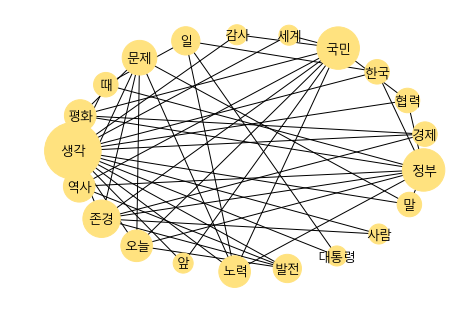

In [2]:
import sys
import ujson
from collections import defaultdict
from collections import Counter
from itertools import combinations
from operator import itemgetter
from gensim import corpora
from gensim import models
import networkx as nx
import matplotlib.pyplot as plt

FEATURE_POSES = ["NC", "NQ"]
INPUT_FILE_NAME = "../data/speeches/nmh_speeches.ma.txt"
MA_KEY = "body_ma"
NUM_TOPICS = 15
NUM_TOPIC_WORDS = 40
NUM_WORD_COOCS = 50


def read_documents(input_file_name):
    """주어진 이름의 파일에서 문서들을 읽어서 돌려준다."""
    
    documents = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue
                        
                    morphs.append(morph_lex)

            documents.append(morphs)

    return documents


def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary


def build_word_cooc_mat(model):
    """주어진 토픽 모델링 결과에서 어휘 공기 행렬을 생성하여 돌려준다."""
    
    word_cooc_mat = defaultdict(Counter)
    topic_documents = get_topic_documents(model)
    
    for topic_document in topic_documents:
        for word1, word2 in combinations(topic_document, 2):
            word_cooc_mat[word1][word2] += 1
            
    return word_cooc_mat
    
    
def get_topic_documents(model):
    """주어진 토픽 모델링 결과에서 토픽 문서를 생성하여 돌려준다."""
    
    topic_documents = []
    
    for topic_id in range(model.num_topics):
        topic_document = []
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)

        for topic_word, prob in topic_word_probs:
            topic_document.append(topic_word)
            
        topic_documents.append(topic_document)
        
    return topic_documents


def build_word_cooc_network(sorted_word_coocs):
    G = nx.Graph()

    for word1, word2, count in sorted_word_coocs[:NUM_WORD_COOCS]:
        G.add_edge(word1, word2, weight=count)

    return G


def get_sorted_word_coocs(word_cooc_mat):
    """주어진 어휘 공기 행렬에서 공기 빈도로 역술 정렬된 행렬을 생성하려 돌려준다."""
    
    word_coocs = []
    
    for word1, word2_counter in word_cooc_mat.items():
        for word2, count in word2_counter.items():
            word_coocs.append((word1, word2, count))
            
    sorted_word_coocs = sorted(word_coocs, key=itemgetter(2), reverse=True)
    
    return sorted_word_coocs


def draw_network(G):
    """주어진 어휘 공기 네트워크를 화면에 표시한다."""
    
    nodes = nx.nodes(G)
    degrees = nx.degree(G)

    node_size = []

    for node in nodes:
        ns = degrees[node] * 200
        node_size.append(ns)
        
    font_name = get_font_name()

    nx.draw(G,
            pos=nx.fruchterman_reingold_layout(G, k=20),
            node_size=node_size,
            node_color="#FFE27F",
            font_family=font_name,
            label_pos=0,  # 0=head, 0.5=center, 1=tail
            with_labels=True,
            font_size=13)

    plt.axis("off")
    # plt.savefig("graph.png")
    plt.show()
    
    
def get_font_name():
    """플랫폼에 따라 화면에 표시할 글꼴 이름을 돌려준다."""
    
    if sys.platform in ["win32", "win64"]:
        font_name = "malgun gothic"
    elif sys.platform == "darwin":
        font_name = "AppleGothic"
        
    return font_name

        
def main():
    """대통령 연설문에서 토픽 모델을 생성하여 어휘 공기 네트워크를 그린다."""
    
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents = read_documents(input_file_name)
    corpus, dictionary = build_doc_term_mat(documents)
    model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                                     id2word=dictionary,
                                     alpha=1)
    word_cooc_mat = build_word_cooc_mat(model)
    sorted_word_coocs = get_sorted_word_coocs(word_cooc_mat)
    G = build_word_cooc_network(sorted_word_coocs)
    draw_network(G)


# 실행
main()

앞선 강의에서 살펴본 대로 위의 네트워크의 근간을 최소 신장 트리를 이용해 살펴보는 것도 가능하다.

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

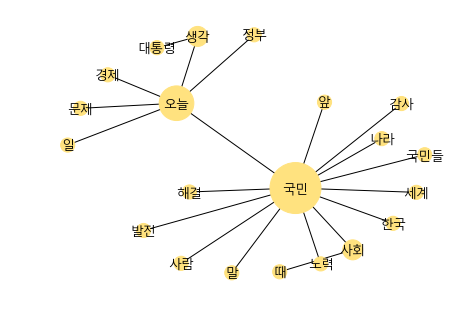

In [3]:
import sys
import ujson
from collections import defaultdict
from collections import Counter
from itertools import combinations
from operator import itemgetter
from gensim import corpora
from gensim import models
import networkx as nx
import matplotlib.pyplot as plt

FEATURE_POSES = ["NC", "NQ"]
MA_KEY = "body_ma"
NUM_TOPICS = 15
NUM_TOPIC_WORDS = 40
NUM_WORD_COOCS = 50


def read_documents(input_file_name):
    """주어진 이름의 파일에서 문서들을 읽어서 돌려준다."""
    
    documents = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue
                        
                    morphs.append(morph_lex)

            documents.append(morphs)

    return documents


def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary


def build_word_cooc_mat(model):
    """주어진 토픽 모델링 결과에서 어휘 공기 행렬을 생성하여 돌려준다."""
    
    word_cooc_mat = defaultdict(Counter)
    topic_documents = get_topic_documents(model)
    
    for topic_document in topic_documents:
        for word1, word2 in combinations(topic_document, 2):
            word_cooc_mat[word1][word2] += 1
            
    return word_cooc_mat
    
    
def get_topic_documents(model):
    """주어진 토픽 모델링 결과에서 토픽 문서를 생성하여 돌려준다."""
    
    topic_documents = []
    
    for topic_id in range(model.num_topics):
        topic_document = []
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)

        for topic_word, prob in topic_word_probs:
            topic_document.append(topic_word)
            
        topic_documents.append(topic_document)
        
    return topic_documents


def build_word_cooc_mst(sorted_word_coocs):
    G = nx.Graph()

    for word1, word2, count in sorted_word_coocs[:NUM_WORD_COOCS]:
        G.add_edge(word1, word2, weight=count)
        
    T = nx.minimum_spanning_tree(G)

    return T


def get_sorted_word_coocs(word_cooc_mat):
    """주어진 어휘 공기 행렬에서 공기 빈도로 역술 정렬된 행렬을 생성하려 돌려준다."""
    
    word_coocs = []
    
    for word1, word2_counter in word_cooc_mat.items():
        for word2, count in word2_counter.items():
            word_coocs.append((word1, word2, count))
            
    sorted_word_coocs = sorted(word_coocs, key=itemgetter(2), reverse=True)
    
    return sorted_word_coocs


def draw_network(G):
    """주어진 어휘 공기 네트워크를 화면에 표시한다."""
    
    nodes = nx.nodes(G)
    degrees = nx.degree(G)

    node_size = []

    for node in nodes:
        ns = degrees[node] * 200
        node_size.append(ns)
        
    font_name = get_font_name()

    nx.draw(G,
            pos=nx.fruchterman_reingold_layout(G, k=0.5),
            node_size=node_size,
            node_color="#FFE27F",
            font_family=font_name,
            label_pos=0,  # 0=head, 0.5=center, 1=tail
            with_labels=True,
            font_size=13)

    plt.axis("off")
    # plt.savefig("graph.png")
    plt.show()
    
    
def get_font_name():
    """플랫폼에 따라 화면에 표시할 글꼴 이름을 돌려준다."""
    
    if sys.platform in ["win32", "win64"]:
        font_name = "malgun gothic"
    elif sys.platform == "darwin":
        font_name = "AppleGothic"
        
    return font_name


def main():
    """대통령 연설문에서 토픽 모델을 생성하여 어휘 공기 네트워크를 그린다."""
    
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents = read_documents(input_file_name)
    corpus, dictionary = build_doc_term_mat(documents)
    model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                                     id2word=dictionary,
                                     alpha=1)
    word_cooc_mat = build_word_cooc_mat(model)
    sorted_word_coocs = get_sorted_word_coocs(word_cooc_mat)
    T = build_word_cooc_mst(sorted_word_coocs)
    draw_network(T)


# 실행
main()

위의 결과는 연설문 전체에 분포한 토픽들의 담화 구조를 드러낸다고 볼 수 있다. 이 결과가 어휘 공기 네트워크로부터 추출된 결과와 얼마나 다른지는 검증이 필요하다.

한편 앞서 설명한 바와 같이 한 개의 문서는 복수 개의 토픽으로 구성되므로 문서별 토픽의 분포를 얻는 것도 가능하다.

In [4]:
import ujson
from gensim import corpora
from gensim import models

FEATURE_POSES = ["NC", "NQ"]
MA_KEY = "body_ma"
NUM_TOPICS = 15
NUM_TOPIC_WORDS = 40


def read_documents(input_file_name):
    """주어진 이름의 파일에서 문서들을 읽어서 돌려준다."""
    
    documents = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue
                        
                    morphs.append(morph_lex)

            documents.append(morphs)

    return documents


def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]

    return corpus, dictionary


def print_document_topics(model, corpus):
    """주어진 토픽 모델링 결과와 문서 어휘 행렬에서 문서별 토픽 분포를 출력한다."""
    
    for doc_num, doc in enumerate(corpus):
        topic_probs = model[doc]
        print("Doc num: {}".format(doc_num))

        for topic_id, prob in topic_probs:
            print("\t{}\t{}".format(topic_id, prob))

        print("\n")   

        
def main():
    """대통령 연설문에서 문서별 토픽 분포를 출력한다."""
    
    input_file_name = "../data/speeches/nmh_speeches.ma.txt"
    documents = read_documents(input_file_name)
    corpus, dictionary = build_doc_term_mat(documents)
    model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                                     id2word=dictionary,
                                     alpha=1)
    print_document_topics(model, corpus)


# 실행
main()

Doc num: 0
	1	0.016741283348101738
	2	0.052493840711114834
	3	0.05526119657918387
	4	0.02167254147568748
	12	0.05736382490138774
	13	0.016245300522786943
	14	0.7338973611325864


Doc num: 1
	0	0.022203938601331456
	1	0.022413912154365334
	2	0.1098324657952399
	3	0.02141797613744821
	4	0.01793192798168501
	5	0.01712366295546201
	6	0.019310353442475635
	7	0.015104261175602362
	8	0.165047821762402
	9	0.01334907575484772
	10	0.012407824105871814
	11	0.016192605937733816
	12	0.4832424629821437
	13	0.032662602868419155
	14	0.03175910834497178


Doc num: 2
	0	0.026955800414756734
	1	0.02288467603904579
	2	0.15922020390643746
	3	0.08044772564541978
	4	0.015617152478475485
	5	0.020231379509060808
	6	0.016580679741789922
	7	0.015225315121675296
	8	0.018614461378921577
	9	0.011020289727405463
	10	0.011902344616865228
	11	0.01299480651937647
	12	0.03321016103432299
	13	0.018832913522003204
	14	0.5362620903444438


Doc num: 3
	0	0.01098027774287977
	2	0.020735327410243393
	3	0.06523962900646482
	4	

위 스크립트의 실행 결과를 이용하여 문서 군집화를 수행하는 등의 추가 분석도 가능하다. 그 클러스터링 결과가 형태소를 자질로 직접 이용한 군집화 결과와 얼마나 차이가 있는지는 검증이 필요하다.

군집화를 문서가 아니라 추출된 토픽들에 적용하여 토픽의 군집화를 시도하는 것도 가능하다.

# 워드 임베딩
## 워드 임베딩이란?
워드 임베딩(word embedding)이란 텍스트에 포함된 단어를 수치화하는 방법의 일종으로 보통 하나의 단어를 실수의 벡터로 나타낸다. 워드 임베딩에는 여러 가지 기법을 사용할 수 있는 최근에 주로 사용되는 기법은 얕은 신경망 기법을 이용하는 것이다.

워드 임베딩을 이용하면 한 단어의 의미를 주변 단어에 의해 효과적으로 표현할 수 있으며, 벡터 연산을 이용하여 의미 연산을 수행할 수 있다.

## 워드 임베딩 방식
### CBOW 임베딩
CBOW(Continuous Bag of Words) 방식은 복수 단어 문맥(multi-word context)이 주어진 상태에서 이후에 나올 단어를 예측하는 방식이다. 

>꼬리가 아홉 개 달린 여우가 재주를 넘었다.

예를 들어 위와 같은 문장이 주어졌을 때, `꼬리가 아홉 개 달린`이라는 문맥이 주어지면 다음에 올 단어은 `여우가`를 예측하는 것이다.

## 스킵 그램 임베딩
스킵 그램(Skip-Gram) 방식은 CBOW 방식과 반대로 특정한 단어로부터 문맥이 될 수 있는 단어를 예측한다. 보통 입력 단어 주변의 $k$ 개 단어를 문맥으로 보고 예측 모형을 만드는데 이  $k$ 값을 윈도우 크기(window size)라고 한다.

위의 예제 문장에서 $k=1$인 경우 다음과 같은 예측을 수행한다.

```
아홉 -> 꼬리가
아홉 -> 개
...
재주를 -> 여우가
재주를 -> 넘었다
```

## 영화 리뷰를 이용한 워드 임베딩 실험

In [7]:
import ujson
import gensim
from gensim.models import Word2Vec

FEATURE_POSES = ["NC", "NQ", "MM", "MA", "PV", "PA"]
PRED_POSES = ["PV", "PA"]
MA_KEY = "document_ma"


def read_documents(input_file_name):
    """주어진 이름의 파일에서 문서들을 읽어서 돌려준다."""
    
    documents = []

    with open(input_file_name, "r", encoding="utf-8") as input_file:
        for line in input_file:
            morphs = []
            json_obj = ujson.loads(line)

            for sent_anal in json_obj[MA_KEY]:
                for morph_lex, morph_cat in sent_anal:
                    if morph_cat not in FEATURE_POSES:
                        continue
                        
                    if morph_cat in PRED_POSES:
                        morph_lex += "다"
                        
                    morphs.append(morph_lex)

            documents.append(morphs)

    return documents


def print_similar_words(model, word, topn=20):
    """주어진 단어와 유사도가 높은 단어들을 출력한다."""
    
    for word, sim in model.similar_by_word(word, topn=topn):
        print("{}\t{}".format(word, sim))   
        
    print()
    
    
def print_most_similar_words(model, positive_words, negative_words):
    for word, sim in model.most_similar(positive=positive_words, 
                                        negative=negative_words):
        print("{}\t{}".format(word, sim))
        
    print()
    
    
def print_not_matching_word(model, words):
    """주어진 단어들 가운데 어울리지 않는 단어를 골라서 출력한다."""
    
    print(model.doesnt_match(words))
    print()


def main():
    """영화 리뷰 문서 집합에 워드 임베딩을 수행하여 어휘 유사도를 산출한다."""
    
    input_file_name = "../data/nsmc/ratings.ma.txt"
    documents = read_documents(input_file_name)
    model = Word2Vec(documents, window=5, min_count=5, size=100)
    
    print_similar_words(model, "하정우")
    print_similar_words(model, "이정재")
    print_similar_words(model, "김혜수")
    print_most_similar_words(model, ["아름답다", "귀엽다"], ["예쁘다"])
    print_not_matching_word(model, ["이정재", "조인성", "하정우", "강동원"])


# 실행
main()

김태희	0.9794262647628784
김민준	0.9671632051467896
블란쳇	0.9655933380126953
오연수	0.9632519483566284
신인	0.963243842124939
엄정화	0.9630140662193298
장근석	0.961457371711731
남상미	0.9606556296348572
주원	0.960269033908844
유오성	0.9593803286552429
주윤발	0.9589032530784607
정재영	0.95853590965271
송지효	0.9584864974021912
동호	0.9581536054611206
전지현	0.957736611366272
강지환	0.9570737481117249
박형식	0.956327497959137
재연배우	0.9562894105911255
키아누	0.9561559557914734
최강희	0.956092119216919

베	0.977973461151123
소이현	0.9772409796714783
크리스찬	0.9766184091567993
제임스	0.9763516187667847
리브스	0.9753822088241577
누님	0.9750803709030151
김창완	0.9745331406593323
레슬리	0.9744082689285278
조커	0.9731349349021912
정우성	0.9728034138679504
키아누	0.9726884961128235
톰크루즈	0.9725480079650879
장신영	0.9722344279289246
키	0.9718121886253357
아놀드	0.9714436531066895
맘에안듬	0.9714215993881226
이동욱	0.971392035484314
문근영	0.9712647199630737
출연작	0.9711107015609741
눈빛연기	0.9709057807922363

조연들	0.9763327836990356
아역	0.9694797992706299
두배우	0.9692440629005432
주연들	0.9678382873535156
최

# 과제
1. 제7강에서 과제로 수행한 전직 대통령 국정전반 연설문의 계층적 군집 분석을 토픽 모델링에 의한 문서별 토픽 분포 유사도에 의한 계층적 군집 분석으로 대체하여 수행하라. 이때 문서 어휘 행렬 대신에 문서 토픽 행렬을 생성하여 사용하라(`numpy.array()` 함수 사용).
1. 위에서 생성한 문서 토픽 행렬에서 문서쌍별 유사도 행렬을 생성하여 문서 유사도 네트워크(최소신장트리)를 시각화하라. 문사쌍별 유사도 행렬의 생성에는 `scipy.spatial.distance.pdist()` 함수를 사용하라.